# Final Fantasy XIV Online - Suffering From Success

### By: Julian Travis

Group Contribution Statement: This is a solo project. Julian completed this project on his own.

## Introduction

Final Fantasy XIV Online (FFXIV) is one of the biggest, if not already the biggest MMORPG (Massively Multiplayer Online Role-Playing Game) on the planet. Recently, with the release of their latest "Endwalker" expansion on December 3, 2021, the game's popularity has surged to the point at which it has begun to *negatively* affect Square Enix (the publisher) and the game's players.

There are so many people trying to play the game every day that at peak hours, players are stuck in over 5,000 person queues just to log into the game! There have been other instances in which the game has had massive queue numbers, including previous expansions and special cases like popular streamers trying out the game.

A specific case of this would be the massive World of Warcraft streamer Asmongold trying the game in July of 2021. This brought so many players to the game that one of the North American data centers for the game became extremely congested; new characters could not be made on it at all. The development team said they would like to address such congestion before the release of Endwalker, but with the advent of COVID-19 and the subsequent collapse of the semiconductor market, they could not upgrade their servers.

This project aims to analyze the growth of the game over the course of its past expansions and predict how congested the game will get by its next expansion in 2023 (a new expansion is released every 2 years with the game's current track record).

The game can be accessed through 2 different methods:
1. The game's official launcher.
2. Steam, a PC-oriented gaming platform.

There is no way to obtain data on players who play through the official launcher, but for those playing through steam, a website called SteamDB keeps track of player records. **As such, we will be using the data from SteamDB and assuming that roughly 50% of players play through steam, while the others use the official launcher instead.**

The SteamDB data can be found here:
https://steamdb.info/app/39210/graphs/

**Note: To see the full chart in the above website, you must be logged into Steam.**

I have uploaded a mirror of the full chart to my GitHub page for this project as well:
https://raw.githubusercontent.com/xeroplz/xeroplz.github.io/main/res/ffxiv_steam_chart.csv

## Part 1 - Parsing the Data

Our dataset is contained in a simple CSV file, with columns titled Datetime, Players, Twitch Viewers, and Flags. It contains periodic entries from February 1, 2014 to December 17, 2021.


The Datetime is the date and time of the recorded entry. 


Players is the concurrent players at the given time. 


Twitch Viewers is the maximum concurrent Twitch.tv viewers for the game at that time.


Flags is an extra label likely used by other charts, but not ours; it is completely empty.


The Twitch Viewers column is not necessary for our analysis, but it will be used to provide insight into certain player spikes, just like the aformentioned incident with Asmongold.

In [1]:
# Import necessary packages
import numpy as np
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import math
from datetime import datetime
from scipy import stats

In [2]:
# Retrieve data from CSV file
data = pd.read_csv("res/ffxiv_steam_chart.csv")
data.head(10)

,DateTime,Players,Twitch Viewers,Flags
0,2014-02-01 00:00:00,7401.0,NaN,NaN
1,2014-02-02 00:00:00,NaN,NaN,NaN
2,2014-02-03 00:00:00,NaN,NaN,NaN
3,2014-02-04 00:00:00,NaN,NaN,NaN
4,2014-02-05 00:00:00,NaN,NaN,NaN
5,2014-02-06 00:00:00,NaN,NaN,NaN
6,2014-02-07 00:00:00,NaN,NaN,NaN
7,2014-02-08 00:00:00,NaN,NaN,NaN
8,2014-02-09 00:00:00,NaN,NaN,NaN
9,2014-02-10 00:00:00,NaN,NaN,NaN


To get this data into a form ready for analysis and graphing, we need to make a new column that is represented as an offset from the first day of the game's operation (02/01/2014).

We also need to drop the Flags, column, and replace all of the NaN values in the other columns with 0.

In [3]:
data = data.drop(['Flags'], axis=1)
data.head(10)

for index, row in data.iterrows():
    if math.isnan(data.at[index, 'Players']):
        data.at[index, 'Players'] = 0.0
        
    if math.isnan(data.at[index, 'Twitch Viewers']):
        data.at[index, 'Twitch Viewers'] = 0.0
        
data.head(10)

,DateTime,Players,Twitch Viewers
0,2014-02-01 00:00:00,7401.0,0.0
1,2014-02-02 00:00:00,0.0,0.0
2,2014-02-03 00:00:00,0.0,0.0
3,2014-02-04 00:00:00,0.0,0.0
4,2014-02-05 00:00:00,0.0,0.0
5,2014-02-06 00:00:00,0.0,0.0
6,2014-02-07 00:00:00,0.0,0.0
7,2014-02-08 00:00:00,0.0,0.0
8,2014-02-09 00:00:00,0.0,0.0
9,2014-02-10 00:00:00,0.0,0.0


In [4]:
type(data.at[0, 'DateTime'])

str

The DateTime column is also seemingly full of strings, so we need to convert these values to datetimes for our future calculations.

In [5]:
for index, row in data.iterrows():
    date_val =  str(data.at[index, 'DateTime'])
    data.at[index, 'DateTime'] = datetime.strptime(date_val,\
        '%Y-%m-%d %H:%M:%S')

print('New DateTime column type: ' + str(type(data.at[0, 'DateTime'])))

New DateTime column type: <class 'datetime.datetime'>


Now, we must finally add a date offset column to the table for our future plotting.

In [6]:
data.insert(loc = 1, column = 'Days From Launch', value = np.nan)
data.head(10)

,DateTime,Days From Launch,Players,Twitch Viewers
0,2014-02-01 00:00:00,NaN,7401.0,0.0
1,2014-02-02 00:00:00,NaN,0.0,0.0
2,2014-02-03 00:00:00,NaN,0.0,0.0
3,2014-02-04 00:00:00,NaN,0.0,0.0
4,2014-02-05 00:00:00,NaN,0.0,0.0
5,2014-02-06 00:00:00,NaN,0.0,0.0
6,2014-02-07 00:00:00,NaN,0.0,0.0
7,2014-02-08 00:00:00,NaN,0.0,0.0
8,2014-02-09 00:00:00,NaN,0.0,0.0
9,2014-02-10 00:00:00,NaN,0.0,0.0


In [7]:
launch_date = data.at[0, 'DateTime']

for index, row in data.iterrows():
    date_val = data.at[index, 'DateTime']
    data.at[index, 'Days From Launch'] = (date_val - launch_date).days
    
data.head(10)

,DateTime,Days From Launch,Players,Twitch Viewers
0,2014-02-01 00:00:00,0.0,7401.0,0.0
1,2014-02-02 00:00:00,1.0,0.0,0.0
2,2014-02-03 00:00:00,2.0,0.0,0.0
3,2014-02-04 00:00:00,3.0,0.0,0.0
4,2014-02-05 00:00:00,4.0,0.0,0.0
5,2014-02-06 00:00:00,5.0,0.0,0.0
6,2014-02-07 00:00:00,6.0,0.0,0.0
7,2014-02-08 00:00:00,7.0,0.0,0.0
8,2014-02-09 00:00:00,8.0,0.0,0.0
9,2014-02-10 00:00:00,9.0,0.0,0.0


The last thing we must worry about is days with their 'Players' value being 0. A peak concurrent player number of 0 means that the game is down, or in maintenance. These numbers would skew our calculations if they were to be included, as they would be massive outliers. They must be removed.

In [8]:
data = data[data.Players != 0]
data.head(10)

,DateTime,Days From Launch,Players,Twitch Viewers
0,2014-02-01 00:00:00,0.0,7401.0,0.0
16,2014-02-17 00:00:00,16.0,1302.0,0.0
17,2014-02-18 00:00:00,17.0,3027.0,0.0
18,2014-02-19 00:00:00,18.0,3018.0,0.0
19,2014-02-20 00:00:00,19.0,3736.0,0.0
20,2014-02-21 00:00:00,20.0,6090.0,0.0
21,2014-02-22 00:00:00,21.0,7401.0,0.0
22,2014-02-23 00:00:00,22.0,7439.0,0.0
23,2014-02-24 00:00:00,23.0,6491.0,0.0
24,2014-02-25 00:00:00,24.0,6547.0,0.0


Finally, our data is ready to be used for analysis!

## Part 2 - Analysis of Data

First, we would like to simply take note of the largest concorrent player spikes in our entire chart, and see what specific events we can attribute to them.

Our expected player spikes are on expansion launch days and major patches.

For reference the expansions of FFXIV were released on the following days:
- Heavensward (3.0): Early Access June 19, 2015 / Official Release June 23, 2015 
- Stormblood (4.0): Early Access June 16, 2017 / Official Release June 20, 2017
- Shadowbringers (5.0): Early Access June 28, 2019 / Official Release July 2, 2019
- Endwalker (6.0): Early Access December 3, 2021 / Official Release December 7, 2021

As such, we expect all 8 of those dates to appear as spikes in our data set when plotted. A noteworthy point is that we cannot simply look for the largest set of values in the chart, as the game's popularity has undoubtedly grown over the years. The number of players on the launch day of Heavensward may not even compare to a normal day towards the end of Shadowbringers. We must look for local spikes in the data instead.

Expansions are not the only source of population growth, as previously mentioned. Special cases like massive twitch streamers joining the game are also a source of growth, so we will be analyzing that data as well.

To start, let's find the days listed in our expansion references above. We need a good identifier for the release dates, so let's calculate the days from launch for our targets.

Days From Launch:
- Heavensward: EA = 503 Days / OR = 507 Days
- Stormblood: EA = 1231 Days / OR = 1235 Days
- Shadowbringers: EA = 1973 Days / OR = 1977 Days
- Endwalker: EA = 2862 Days / OR = 2866 Days

In [9]:
launch_days = [503, 507, 1231, 1235, 1973, 1977, 2862, 2866]
data[data['Days From Launch'].isin(launch_days)]

,DateTime,Days From Launch,Players,Twitch Viewers
503,2015-06-19 00:00:00,503.0,10838.0,0.0
507,2015-06-23 00:00:00,507.0,10598.0,0.0
1231,2017-06-16 00:00:00,1231.0,22451.0,29185.0
1235,2017-06-20 00:00:00,1235.0,22471.0,30609.0
1973,2019-06-28 00:00:00,1973.0,35077.0,31253.0
1977,2019-07-02 00:00:00,1977.0,33878.0,17255.0
2862,2021-12-03 00:00:00,2862.0,87831.0,81650.0
2866,2021-12-07 00:00:00,2866.0,86965.0,28545.0


We can clearly see that the game's popularity has indeed grown over time. The amount of concurrent players on the Heavensward launch day is only an 8th of those no the Endwalker launch day. We must detect a trend in growth between these values.

We also must detect the largest 'Twitch Viewers' values that do **not** occur on the dates we just listed above; this will give us more points to accurately analyze and predict future populations for the game..

In [10]:
data_twitch = data.sort_values(by = ['Twitch Viewers'], ascending = False)
data_twitch = data_twitch[np.logical_not(data_twitch['Days From Launch']\
                                         .isin(launch_days))]
data_twitch.head(20)

,DateTime,Days From Launch,Players,Twitch Viewers
2709,2021-07-03 00:00:00,2709.0,42068.0,221605.0
2710,2021-07-04 00:00:00,2710.0,47542.0,199007.0
2717,2021-07-11 00:00:00,2717.0,58046.0,162904.0
2562,2021-02-06 00:00:00,2562.0,30680.0,149220.0
2660,2021-05-15 00:00:00,2660.0,32324.0,144282.0
2724,2021-07-18 00:00:00,2724.0,67148.0,140160.0
1876,2019-03-23 00:00:00,1876.0,14242.0,134069.0
2786,2021-09-18 00:00:00,2786.0,47927.0,131646.0
2714,2021-07-08 00:00:00,2714.0,44846.0,130242.0
2712,2021-07-06 00:00:00,2712.0,44888.0,130198.0


We can see that plenty of the largest Twitch Viewer entries occur within the weeks that Asmongold started playing FFXIV, so we should expect an extreme concurrent player spike in the weeks following July 3, 2021 (or 2709 days after launch).

Now that we have a good idea of all of the local and persistent longtime spikes in our data, we can plot our data and see whether our conceptions check out.

<Figure size 432x288 with 0 Axes>

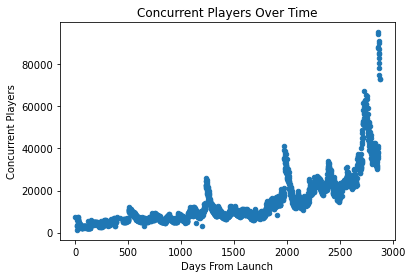

In [11]:
plt.figure()
ax1 = data.plot.scatter(x = 'Days From Launch', y = 'Players',\
    title='Concurrent Players Over Time')
plt.xlabel('Days From Launch')
plt.ylabel('Concurrent Players')
plt.show()

We can see that the chart perfectly aligns with our assumptions. The expansion releases are the local maxima that begin to shape the curve, with a special exception to the extreme popularity boost the game got when Asmongold joined.

Our goal is to predict future congestion, so ideally we want to predict the absolute maximum by the next expansion. For this, we should isolate the maxima and perform linear regression.

We should also perform a second regression on the entire dataset to provide predictions for the post-maxima set of concurrent players, which will more closely represent the game's resting population.

## Part 3 - Creating a Good Model

First, let us begin with our first goal - predicting peak congestion on the next expansion's launch. We want to use the local maxima of the graph, which include the launch dates of each expansion AND Asmongold's first day on the game - July 3, 2021.

Text(0.5, 1.0, 'Concurrent Players on Historical Dates')

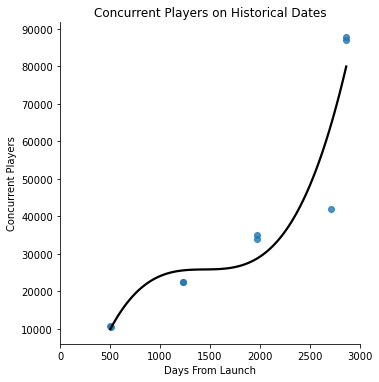

In [12]:
peak_days = launch_days.copy()
peak_days.append(2709)

# Set regression order for the peak data
reg_order_peak = 3

# Get a dataframe of data only from the peak days
data_peak = data[data['Days From Launch'].isin(peak_days)]

# Create graph with line of best fit
lnpl = sns.lmplot(x = 'Days From Launch', y = 'Players', data = data_peak,\
    fit_reg = True, order = reg_order_peak, ci = None,\
    line_kws = {"color": "black"})
lnpl.set(xlabel = 'Days From Launch', ylabel = 'Concurrent Players')
lnpl.set(xlim = (0, 3000))
ax = plt.gca()
ax.set_title("Concurrent Players on Historical Dates")

In [13]:
# Now we need to find the equation for this line!
peak_fit = np.polyfit(\
    data_peak['Days From Launch'], data_peak['Players'], reg_order_peak)

print(peak_fit)

[ 1.87121201e-05 -8.11163803e-02  1.17524943e+02 -3.10833755e+04]


Now we know that the line of best fit for our peak concurrent users has the above coefficients. We can use these to easily make predictions with a function.

In [14]:
linreg_peak = np.poly1d(peak_fit)

Now, we make a residual plot to figure out how well our regression line does against our real data.

<Figure size 432x288 with 0 Axes>

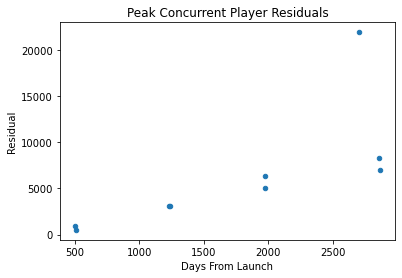

In [15]:
data_peak.insert(loc = 4, column = 'Residual', value = np.nan)

for i in peak_days:
    day_rows = data_peak.loc[data_peak['Days From Launch'] == i]
    for index, row in day_rows.iterrows():
        residual = np.absolute(linreg_peak(i) - row['Players'])
        data_peak.at[index, 'Residual'] = residual
    
# Draw violin plot
plt.figure()
ax1 = data_peak.plot.scatter(x = 'Days From Launch', y = 'Residual',\
    title='Peak Concurrent Player Residuals')
plt.xlabel('Days From Launch')
plt.ylabel('Residual')
plt.show()

These residuals seem quite troublesome, especially the July 3, 2021 entry. This means it is quite the outlier in the trend, but we do not have many more peak points to go on if we are to predict peak congestion by the next expansion. A large margin of error is expected here.

Let's continue analysis on the entire graph this time, to get a more consistent line of best fit for the rest of the chart. A regression on the entire dataset may provide a better guess at future values, even if it may not predict the initial expansion release congestion.

Text(0.5, 1.0, 'Concurrent Players Over Time')

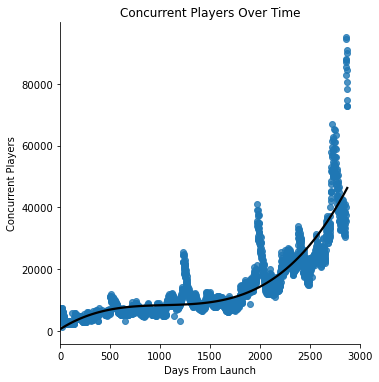

In [16]:
# Regression order for all of the data overall
reg_order_overall = 3

# Create graph with line of best fit
lnpl = sns.lmplot(x = 'Days From Launch', y = 'Players', data = data,\
    fit_reg = True, order = reg_order_overall, ci = None,\
    line_kws = {"color": "black"})
lnpl.set(xlabel = 'Days From Launch', ylabel = 'Concurrent Players')
lnpl.set(xlim = (0, 3000))
ax = plt.gca()
ax.set_title("Concurrent Players Over Time")

In [17]:
# Find equation for the line
overall_fit = np.polyfit(\
    data['Days From Launch'], data['Players'], reg_order_overall)

print(overall_fit)

linreg_overall = np.poly1d(overall_fit)

[ 5.97532505e-06 -1.88189253e-02  2.05902483e+01  5.79850704e+02]


And now to test the residuals for this model...

<Figure size 432x288 with 0 Axes>

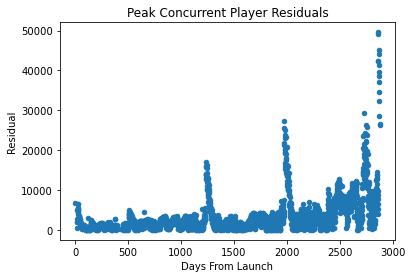

In [18]:
data.insert(loc = 4, column = 'Residual', value = np.nan)

for index, row in data.iterrows():
    residual = np.absolute(linreg_overall(\
        row['Days From Launch']) - row['Players'])
    data.at[index, 'Residual'] = residual
    
# Draw violin plot
plt.figure()
ax1 = data.plot.scatter(x = 'Days From Launch', y = 'Residual',\
    title='Peak Concurrent Player Residuals')
plt.xlabel('Days From Launch')
plt.ylabel('Residual')
plt.show()

As shown by the above residual plot, the residuals are relatively low, minus the spikes which are unaccounted for by the general trend. This lines up with our expectations, so it seems we have a good model. Increasing the polynomial degree did not do much to decrease the outlying residuals either.

## Part 4 - Using our Models for Prediction

Now that we have good models set up for our values, all we need to do is plug some future numbers in for both our peak and overall models. We also need to account for the standard duration of a peak, be it 10 or 20 days overall.

First, we should find out just how long a peak lasts. The duration of the Shadowbringers peak would be a good place to look!

In [19]:
data[(data['Days From Launch'] >= 1973) & (data['Players'] <= 20000)].head()

,DateTime,Days From Launch,Players,Twitch Viewers,Residual
2028,2019-08-22 00:00:00,2028.0,19343.0,9557.0,4565.751833
2029,2019-08-23 00:00:00,2029.0,18899.0,9118.0,4103.747941
2032,2019-08-26 00:00:00,2032.0,19619.0,5649.0,4769.525487
2033,2019-08-27 00:00:00,2033.0,18098.0,4782.0,3230.380956
2034,2019-08-28 00:00:00,2034.0,18511.0,6120.0,3625.201177


The first occurrence of a return to normalcy after the Shadowbringers release peak was the 2028th day; 55 days after Shadowbringers Early Access. We can assume a peak will last around 60 days with this information.

Keep in mind that we do not have a function for the *dropoff* after a peak, so we will only be able to predict the peak itself and the ~60 days after the peak, when normalcy returns. These are the only conditions are models are able to handle.

Now, it's time to start predicting. Given every expansion releases within 2 years of another, we can assume the next expansion will release on December 3, 2023 (3592 days from launch). We can start predicting the normal population numbers around 60 days after (3752 days from launch).

We first need to fill in the missing data between our last entry, December 17, 2021 (2876 days after launch), and December 3, 2023.

In [20]:
import datetime as dt

for i in range(2876, 3592):
    dict = {'DateTime': [datetime(2014, 2, 1) + dt.timedelta(days = i)],\
        'Days From Launch': [i],\
        'Players': [math.floor(linreg_overall(i))],\
        'Twitch Viewers': [0], 'Residual': [0]}
    to_append = pd.DataFrame(dict)
    data = data.append(to_append, ignore_index = True)

Next, we add December 3, 2023 itself.

In [21]:
# Add December 3, 2023 to the dataframe
dict = {'DateTime': [datetime(2014, 2, 1) + dt.timedelta(days = 3592)],\
    'Days From Launch': [3592],\
    'Players': [math.floor(linreg_peak(3592))],\
    'Twitch Viewers': [0], 'Residual': [0]}
to_append = pd.DataFrame(dict)

data = data.append(to_append, ignore_index = True)

This will be the predicted peak value for the next expansion.

Next, we calculate the next 500 days, 60 days after the peak to give us a good chunk of predicted information.

In [22]:
prediction_range = 3752 + 501
for i in range(3752, prediction_range):
    dict = {'DateTime': [datetime(2014, 2, 1) + dt.timedelta(days = i)],\
        'Days From Launch': [i],\
        'Players': [math.floor(linreg_overall(i))],\
        'Twitch Viewers': [0], 'Residual': [0]}
    to_append = pd.DataFrame(dict)
    data = data.append(to_append, ignore_index = True)

Finally, we plot our new dataset and see how much FFXIV has grown by April 16, 2025!

<Figure size 432x288 with 0 Axes>

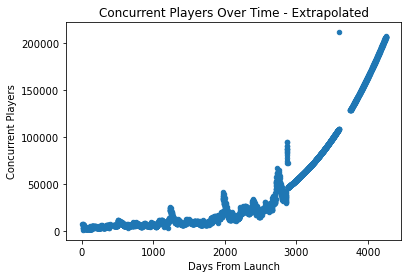

In [23]:
plt.figure()
ax1 = data.plot.scatter(x = 'Days From Launch', y = 'Players',\
    title='Concurrent Players Over Time - Extrapolated')
plt.xlabel('Days From Launch')
plt.ylabel('Concurrent Players')
plt.show()

With this model, we can see that on the next expansion's release, over 200,000 people will be trying to play the game! After it settles, well over 125,000 regular players will be online and its popularity will continue to grow over the years.

At present, Square Enix's infrastructure would absolutely not be able to handle this! Of course it's all prediction, but they would have to do massive upgrades if the game continues to gain popularity at its current rate.

Currently, Square Enix has actually stopped sales of the game to prevent it from getting any more popular, and now we can see why!

The amount of demand on their servers and the shortage of server upgrade opportunities has been a massive struggle for Square Enix in regard to FFXIV, so more growth will certainly harm their business at this rate. Hopefully, they find some solutions soon, or they will have a lot of disappointed future players!

Thank you for your time!